In [32]:
import pandas as pd

df = pd.read_csv("../datas/interim/matched_edits.csv")
print(df["user"].nunique(), "unique users found")
print(df["user"].value_counts().head(10))  # Top users by edit count

402 unique users found
user
LSGH               368
TheDraperyFalls    310
Toddy1             200
UP9                186
Euroserhi           90
Illythr             51
Irpen               45
Criztu              40
Wetman              37
Zello               34
Name: count, dtype: int64


In [33]:
# anonymous users (IPs) or missing usernames
df["is_anon"] = df["user"].str.contains(r"^\d{1,3}\.", na=False)  # simple IP check
print(df["is_anon"].value_counts())

is_anon
False    2281
True      403
Name: count, dtype: int64


In [34]:
df["weaponised"].unique()

array(['Not Weaponised', 'Weaponised', 'weaponised', 'Unknown'],
      dtype=object)

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

df["year"] = pd.to_datetime(df["date"], errors="coerce").dt.year

# Drop the rows without valid year or weaponised label..
df = df.dropna(subset=["year", "weaponised"])

# Ensure correct types
df["year"] = df["year"].astype(int)

# Normalizing the weaponised field because there are some capitalised and soem not --> lowercase and strip
df["weaponised"] = df["weaponised"].astype(str).str.strip().str.lower()
df["weaponised"] = df["weaponised"].replace({
    "true": "Weaponised",
    "false": "Not Weaponised",
    "unknown": "Unknown",
    "weaponised": "Weaponised",
    "not weaponised": "Not Weaponised"
})

df["weaponised"].unique()

array(['Not Weaponised', 'Weaponised', 'Unknown'], dtype=object)

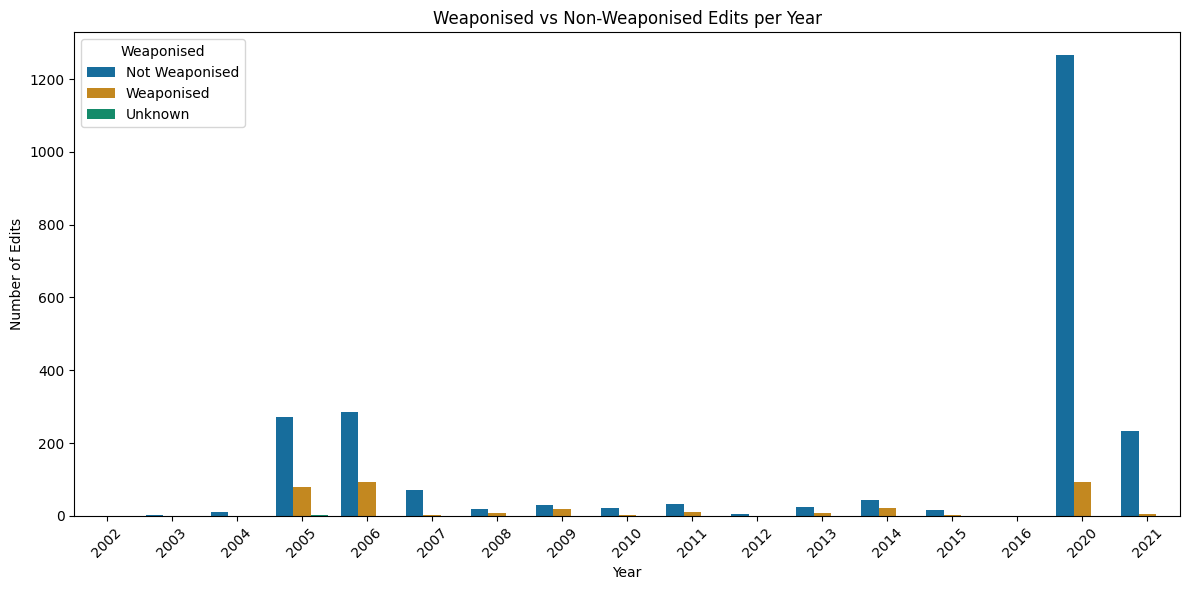

In [37]:
df_counts = df.groupby(["year", "weaponised"]).size().reset_index(name="count")

sns.set_palette("colorblind")
plt.figure(figsize=(12, 6))
sns.barplot(data=df_counts, x="year", y="count", hue="weaponised")

plt.title("Weaponised vs Non-Weaponised Edits per Year")
plt.xlabel("Year")
plt.ylabel("Number of Edits")
plt.legend(title="Weaponised")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [72]:
# top 10 users by number of comments
top_users = (
    df[df["comment"].notna()]
    .groupby("user")
    .size()
    .sort_values(ascending=False)
    .head(10)
    .index
)


In [76]:
top_users = list(top_users)
top_users

['LSGH',
 'TheDraperyFalls',
 'UP9',
 'Toddy1',
 'Illythr',
 'Irpen',
 'Criztu',
 'Wetman',
 'Euroserhi',
 'Bogdangiusca']

In [77]:
# jsut a subset of data for now
df_top = df[df["user"].isin(top_users)]

# count edits per (user, year, weaponised)
grouped = (
    df_top.groupby(["user", "year", "weaponised"])
    .size()
    .reset_index(name="count")
)
grouped

,user,year,weaponised,count
0,Bogdangiusca,2005,Not Weaponised,34
1,Criztu,2005,Not Weaponised,40
2,Euroserhi,2020,Not Weaponised,87
3,Euroserhi,2020,Weaponised,3
4,Illythr,2006,Not Weaponised,17
5,Illythr,2006,Weaponised,34
6,Irpen,2005,Not Weaponised,1
7,Irpen,2006,Not Weaponised,31
8,Irpen,2006,Weaponised,13
9,LSGH,2020,Not Weaponised,195


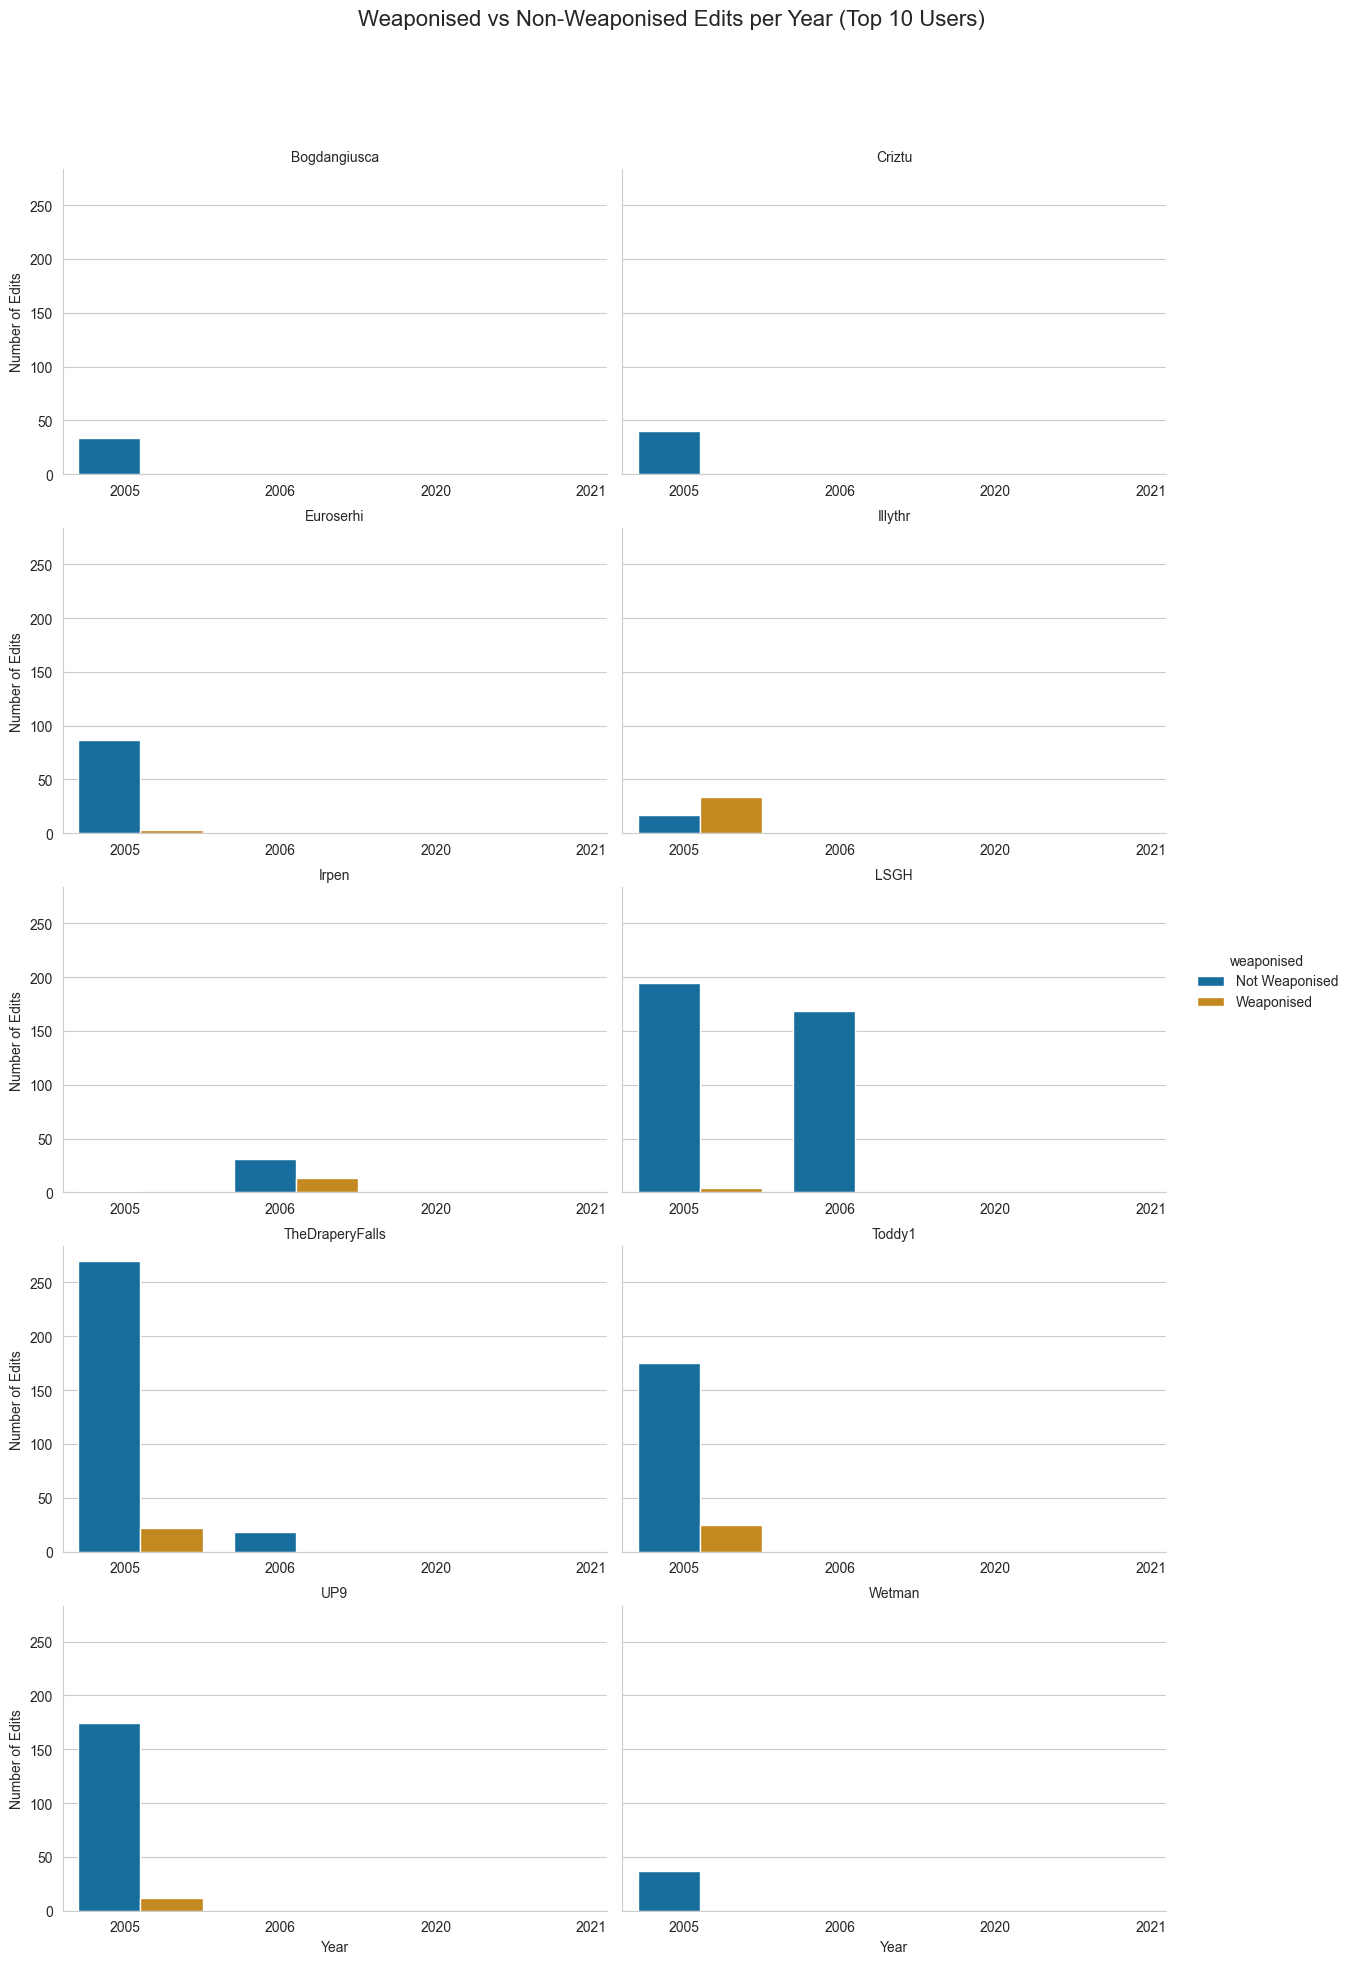

In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_palette("colorblind")
sns.set_style("whitegrid")

grouped["year"] = grouped["year"].astype(str)

# get all years to use for x-axis labels, they are not show by default for some reason
all_years = sorted(grouped["year"].unique())

g = sns.catplot(
    data=grouped,
    kind="bar",
    x="year",
    y="count",
    hue="weaponised",
    col="user",
    col_wrap=2,
    height=4,
    aspect=1.5,
    sharey=True,
    sharex=False
)

g.set_titles("{col_name}")
g.set_axis_labels("Year", "Number of Edits")
g.fig.suptitle("Weaponised vs Non-Weaponised Edits per Year (Top 10 Users)", fontsize=16)

for ax in g.axes.flat:
    ax.set_xticks(range(len(all_years)))
    ax.set_xticklabels(all_years, rotation=00, ha='right')

g.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

## General info about users

In [22]:
import requests
import time

HEADERS = {
    "User-Agent": "EmanuelaBoros/1.0 (emanuela.boros@epfl.ch) Python/requests"
}

def get_user_info(username, max_retries=3, backoff=1.0):
    session = requests.Session()
    session.headers.update(HEADERS)
    url = "https://en.wikipedia.org/w/api.php"

    params = {
        "action": "query",
        "list": "users",
        "ususers": username,
        "usprop": "blockinfo|groups|editcount|registration|emailable|gender",
        "format": "json"
    }

    for attempt in range(max_retries):
        try:
            response = session.get(url=url, params=params, timeout=10)

            if response.status_code != 200:
                return {
                    "user": username,
                    "error": f"HTTP {response.status_code}"
                }

            try:
                data = response.json()
            except ValueError:
                return {
                    "user": username,
                    "error": "Invalid JSON response"
                }

            if "query" in data and "users" in data["query"]:
                return data["query"]["users"][0]
            else:
                return {
                    "user": username,
                    "error": "Missing 'users' in response"
                }

        except Exception as e:
            error_msg = str(e)
            time.sleep(backoff * (2 ** attempt))  # Exponential backoff

    return {
        "user": username,
        "error": f"Failed after {max_retries} attempts"
    }

In [78]:
top_users

['LSGH',
 'TheDraperyFalls',
 'UP9',
 'Toddy1',
 'Illythr',
 'Irpen',
 'Criztu',
 'Wetman',
 'Euroserhi',
 'Bogdangiusca']

In [79]:
user_metadata = [get_user_info(user) for user in top_users]

In [80]:
len(user_metadata)

10

In [81]:
user_metadata[0]

{'userid': 38910429,
 'name': 'LSGH',
 'editcount': 59406,
 'registration': '2020-04-02T10:23:20Z',
 'groups': ['extendedconfirmed', '*', 'user', 'autoconfirmed'],
 'emailable': '',
 'gender': 'unknown'}

In [82]:
user_metadata = pd.DataFrame(user_metadata)

user_metadata.to_csv("../datas/interim/user_profiles.csv", index=False)
user_metadata.head()

,userid,name,editcount,registration,groups,emailable,gender,blockid,blockedby,blockedbyid,blockreason,blockedtimestamp,blockexpiry,blocknocreate,blockemail,blockowntalk,blockedtimestampformatted
0,38910429,LSGH,59406,2020-04-02T10:23:20Z,"[extendedconfirmed, *, user, autoconfirmed]",,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,15458982,TheDraperyFalls,11308,2011-10-04T07:05:08Z,"[extendedconfirmed, *, user, autoconfirmed, oa...",,male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9761029,UP9,390,2009-05-25T17:33:35Z,"[*, user, autoconfirmed, oathauth-twofactorauth]",,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3132940,Toddy1,51941,2006-12-30T16:29:31Z,"[autoreviewer, extendedconfirmed, reviewer, ro...",,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,848299,Illythr,8903,2006-01-27T22:40:20Z,"[extendedconfirmed, reviewer, rollbacker, *, u...",,male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## General info about the user's edits

In [83]:
from collections import Counter
import requests
import time

def get_edit_years(username, max_count=500):
    """
    Returns a Counter of edits per year for a given user.
    Limits to `max_count` edits for performance.
    """
    url = "https://en.wikipedia.org/w/api.php"

    params = {
        "action": "query",
        "list": "usercontribs",
        "ucuser": username,
        "uclimit": "max",
        "ucprop": "timestamp",
        "format": "json"
    }

    session = requests.Session()
    session.headers.update(HEADERS)

    edits_per_year = Counter()
    total_collected = 0
    cont = {}

    while total_collected < max_count:
        if cont:
            params.update(cont)
        
        try:
            response = session.get(url, params=params, timeout=10)
            data = response.json()
        except Exception:
            break

        contribs = data.get("query", {}).get("usercontribs", [])
        for contrib in contribs:
            year = contrib["timestamp"][:4]
            edits_per_year[year] += 1
            total_collected += 1
            if total_collected >= max_count:
                break

        cont = data.get("continue", {})
        if not cont:
            break

        time.sleep(0.5)  # wait

    return edits_per_year

### Number of edits in general that the user does

In [94]:
edits = get_edit_years("UP9", max_count=5000)

print(edits)

Counter({'2020': 205, '2009': 64, '2010': 31, '2021': 26, '2019': 21, '2017': 9, '2016': 9, '2018': 6, '2013': 6, '2012': 6, '2015': 4, '2022': 3, '2014': 1})


In [92]:
grouped[grouped['user'] == 'UP9']


,user,year,weaponised,count
17,UP9,2020,Not Weaponised,174
18,UP9,2020,Weaponised,12


In [95]:
edits['2020']

205

This probably means that the user UP9 did 19 edits somewhere else (maybe not focused on Ukraine), however 186 out of 205 edits were focused on the same subject.

In [85]:
from tqdm import tqdm

user_metadata["edits_per_year"] = None

# Iterate through each user
for idx, row in tqdm(user_metadata.iterrows(), total=len(user_metadata), desc="Fetching edits per user"):
    username = row["name"]
    edits = get_edit_years(username, max_count=500)
    user_metadata.at[idx, "edits_per_year"] = edits

# expand edits_per_year into separate columns
expanded_edits = user_metadata["edits_per_year"].apply(lambda x: pd.Series(x) if isinstance(x, dict) else pd.Series())
user_metadata = pd.concat([user_metadata.drop(columns=["edits_per_year"]), expanded_edits, pd.Series(user_metadata["edits_per_year"], name="edits_per_year_dict")], axis=1)

user_metadata.to_csv("../datas/interim/user_profiles_with_edits.csv", index=False)

Fetching edits per user: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.02it/s]


In [88]:
user_metadata.iloc[0]

userid                                                          38910429
name                                                                LSGH
editcount                                                          59406
registration                                        2020-04-02T10:23:20Z
groups                       [extendedconfirmed, *, user, autoconfirmed]
emailable                                                               
gender                                                           unknown
blockid                                                              NaN
blockedby                                                            NaN
blockedbyid                                                          NaN
blockreason                                                          NaN
blockedtimestamp                                                     NaN
blockexpiry                                                          NaN
blocknocreate                                      

In [87]:
user_metadata.head()

,userid,name,editcount,registration,groups,emailable,gender,blockid,blockedby,blockedbyid,...,2014,2013,2012,2010,2009,2008,2011,2007,2006,edits_per_year_dict
0,38910429,LSGH,59406,2020-04-02T10:23:20Z,"[extendedconfirmed, *, user, autoconfirmed]",,unknown,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{'2022': 500}
1,15458982,TheDraperyFalls,11308,2011-10-04T07:05:08Z,"[extendedconfirmed, *, user, autoconfirmed, oa...",,male,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'2025': 10, '2024': 357, '2023': 133}"
2,9761029,UP9,390,2009-05-25T17:33:35Z,"[*, user, autoconfirmed, oathauth-twofactorauth]",,unknown,NaN,NaN,NaN,...,1.0,6.0,6.0,31.0,64.0,NaN,NaN,NaN,NaN,"{'2022': 3, '2021': 26, '2020': 205, '2019': 2..."
3,3132940,Toddy1,51941,2006-12-30T16:29:31Z,"[autoreviewer, extendedconfirmed, reviewer, ro...",,unknown,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{'2025': 500}
4,848299,Illythr,8903,2006-01-27T22:40:20Z,"[extendedconfirmed, reviewer, rollbacker, *, u...",,male,NaN,NaN,NaN,...,193.0,265.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'2025': 2, '2023': 1, '2022': 3, '2021': 6, '..."


## How to continue from here

* Now we have:
     * `user_profiles_with_edits.csv`: Metadata and total edit counts per user/year.
     * `matched_edits.csv`: All detected Wikipedia edits, with LLM analysis and weaponisation labels.
* Questions:
     * Out of all edits they usually do per year, how many (or percentages) are made regarding Ukraine? any bias towards this subject?
         * Do certain users specialise in certain themes or articles
         * Are weaponising users connected indirectly through editing the same pages? (co-editing networks).
         * Do harmful users persist over time or appear only for specific political events?
         * Do some users evolve: starting neutral, then becoming more harmful, or vice versa?
     * Users typology: let's look at the groups, to:
         * identify admin users vs. regular users (check the groups column)?
         * identify blocked users;
         * and then compare weaponisation patterns (weaponised/no weaponised) across the groups and the users (are those that are blocked writing more weaponised content?)
     * besides weaponised, not weaponised: look at the fine grained labels (in `matched_edits.csv` in `category_extracted_clean` and `category_extracted_propaganda_mapped`), per year, per user, per groups;
     * What to do with the comments of the users?
     * How to include the llm output? the analysis?